In [92]:
import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump, load
from tqdm import tqdm
from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set warnings 
warnings.filterwarnings('ignore')


In [93]:
path = 'data/nasa.csv'
data = pd.read_csv(path)
data.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.600,0.127,0.284,127.220,284.472,0.079,0.177,417.388,...,314.374,609.600,0.808,57.257,2.006,2458161.642,264.838,0.591,J2000,True
1,3723955,3723955,21.300,0.146,0.327,146.068,326.618,0.091,0.203,479.226,...,136.717,425.869,0.718,313.092,1.497,2457794.969,173.741,0.845,J2000,False
2,2446862,2446862,20.300,0.232,0.518,231.502,517.654,0.144,0.322,759.521,...,259.476,643.580,0.951,248.415,1.967,2458120.468,292.894,0.559,J2000,True
3,3092506,3092506,27.400,0.009,0.020,8.801,19.681,0.005,0.012,28.876,...,57.173,514.082,0.984,18.708,1.528,2457902.337,68.741,0.700,J2000,False
4,3514799,3514799,21.600,0.127,0.284,127.220,284.472,0.079,0.177,417.388,...,84.629,495.598,0.968,158.264,1.484,2457814.455,135.142,0.726,J2000,True


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

In [95]:
print(f"Is any data NA: {data.isna().any().any()}")

Is any data NA: False


In [96]:
# plt.figure(figsize=(40,40))
# sb.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f')
# plt.show()

In [97]:
print(f"Unique Equinox values: {data['Equinox'].nunique()}")
print(f"Unique Orbiting Body values: {data['Orbiting Body'].nunique()}")

data = data.drop(['Name', 'Neo Reference ID', 'Orbit ID',   # IDs
                    'Orbit Determination Date', 'Close Approach Date', # Date
                    'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 
                    'Relative Velocity km per hr', 'Miles per hour', 
                    'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(miles)',
                    'Equinox',            # all 'J2000' 
                    'Orbiting Body',      # all 'Earth'
                    'Orbital Period',     # T² = const * a³, => corr = 1 with Semi Major Axis (a)
                    'Est Dia in KM(max)', # High correlation with Est Dia in KM(min)
                    'Jupiter Tisserand Invariant', # High correlation with Mean Motion
                    'Epoch Osculation',   # High correlation with Perihelion Time
                    'Aphelion Dist',      # High correlation with Semi Major Axis
                    ] , axis = 1)

data['Hazardous'] = data['Hazardous'].astype(int)

data.head()

Unique Equinox values: 1
Unique Orbiting Body values: 1


,Absolute Magnitude,Est Dia in KM(min),Epoch Date Close Approach,Relative Velocity km per sec,Miss Dist.(kilometers),Orbit Uncertainity,Minimum Orbit Intersection,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Perihelion Distance,Perihelion Arg,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.600,0.127,788947200000,6.116,62753692.000,5,0.025,0.426,1.407,6.026,314.374,0.808,57.257,2458161.642,264.838,0.591,1
1,21.300,0.146,788947200000,18.114,57298148.000,3,0.187,0.352,1.108,28.413,136.717,0.718,313.092,2457794.969,173.741,0.845,0
2,20.300,0.232,789552000000,7.591,7622911.500,0,0.043,0.348,1.459,4.238,259.476,0.951,248.415,2458120.468,292.894,0.559,1
3,27.400,0.009,790156800000,11.174,42683616.000,6,0.006,0.217,1.256,7.906,57.173,0.984,18.708,2457902.337,68.741,0.700,0
4,21.600,0.127,790156800000,9.841,61010824.000,1,0.035,0.210,1.226,16.793,84.629,0.968,158.264,2457814.455,135.142,0.726,1


In [98]:
# plt.figure(figsize=(40,40))
# sb.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f')
# plt.show()

## Dropping outliers

In [99]:
# plt.figure(figsize=(40, 40))
# sb.pairplot(data.dropna(), hue='Hazardous')
# plt.show()

In [100]:
# TODO: Add function 
df_no_outliers = data[(data['Est Dia in KM(min)'] <= 10) & 
                   (data['Semi Major Axis'] <= 4) &
                   (data['Inclination'] < 70)]
df_no_outliers.reset_index(inplace=True, drop=True)

print(f"Number of objects before: {data.shape[0]}, after: {df_no_outliers.shape[0]}, dropped: {data.shape[0] - df_no_outliers.shape[0]} objects.")

df_no_outliers.info()

Number of objects before: 4687, after: 4683, dropped: 4 objects.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4683 entries, 0 to 4682
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4683 non-null   float64
 1   Est Dia in KM(min)            4683 non-null   float64
 2   Epoch Date Close Approach     4683 non-null   int64  
 3   Relative Velocity km per sec  4683 non-null   float64
 4   Miss Dist.(kilometers)        4683 non-null   float64
 5   Orbit Uncertainity            4683 non-null   int64  
 6   Minimum Orbit Intersection    4683 non-null   float64
 7   Eccentricity                  4683 non-null   float64
 8   Semi Major Axis               4683 non-null   float64
 9   Inclination                   4683 non-null   float64
 10  Asc Node Longitude            4683 non-null   float64
 11  Perihelion Distance           4683 non-null   float64
 1

In [101]:
# plt.figure(figsize=(40, 40))
# sb.pairplot(df_no_outliers.dropna(), hue='Hazardous')
# plt.show()

In [102]:
clean_data_path = 'data/nasa_clean.csv'
print(f"Saving data to {clean_data_path} ...")
df_no_outliers.to_csv(clean_data_path, index=False)

Saving data to data/nasa_clean.csv ...


## Models training

In [103]:
X = df_no_outliers.drop(['Hazardous'], axis=1)
y = df_no_outliers['Hazardous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [104]:
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer([
    ("num", numerical_transformer, X.columns.to_list()),
])

preprocessor.fit(X_train)

x_train_transformed = preprocessor.transform(X_train)
x_test_transformed = preprocessor.transform(X_test)

x_train_transformed.shape

(3746, 16)

In [105]:
def model_evaluation(x, y, models):
    
    names = []
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    
    # Create a dataframe to store the different metric values for each algorithm
    df_results = pd.DataFrame(columns=['Algorithm', 'Acc Mean', 'Acc STD', 'Pre Mean', 'Pre STD', 
                                       'Rec Mean', 'Rec STD', 'F1 Mean', 'F1 STD', 'Training Time'])
    results_acc = []
    results_pre = []
    results_rec = []
    results_f1 = [] 
    confusion_matrices = []
    
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for name, model in tqdm(models, total=len(models)):
        names.append(name)

        result = cross_validate(model, x, y, cv=kfold, scoring=scoring)
        y_pred = cross_val_predict(model, x, y, cv=kfold)
        cm = confusion_matrix(y, y_pred)

        confusion_matrices.append(cm)
        
        # Create the row of the results
        model_results  = pd.DataFrame({'Algorithm': name, 
                                        'Acc Mean': result['test_accuracy'].mean(), 
                                        'Acc STD': result['test_accuracy'].std(), 
                                        'Pre Mean': result['test_precision'].mean(), 
                                        'Pre STD': result['test_precision'].std(), 
                                        'Rec Mean': result['test_recall'].mean(), 
                                        'Rec STD': result['test_recall'].std(), 
                                        'F1 Mean': result['test_f1'].mean(), 
                                        'F1 STD': result['test_f1'].std(),
                                        'Training Time': result['fit_time'].mean(),
                                        }, index=[0])
        
        # Add the row to the results data frame
        if not model_results.empty:
            df_results = pd.concat([df_results, model_results], ignore_index=True)
        
        results_acc.append(result['test_accuracy'])
        results_pre.append(result['test_precision'])
        results_rec.append(result['test_recall'])
        results_f1.append(result['test_f1'])

        # save model.
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        dump(model, f'models/{name}_{current_time}_.joblib')

    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    pd.set_option('display.width', 1000)
    print(df_results)
    


    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

    plot_titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    results_list = [results_acc, results_pre, results_rec, results_f1]

    palette = sb.color_palette("hls", 8)
    for ax, title, result in zip(axes, plot_titles, results_list):
        sb.boxplot(data=result, ax=ax, palette=palette)
        ax.set_title(title, fontsize=14)
        ax.set_xticklabels(names, rotation=30)

    plt.tight_layout()
    plt.show()

    

    fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 4))
    if len(models) == 1:
        axes = [axes]
    for ax, cm, name in zip(axes, confusion_matrices, names):
        sb.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", ax=ax, cmap='Blues')
        ax.set_title(f'{name} Confusion Matrix')
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
    plt.tight_layout()
    plt.show()

100%|██████████| 6/6 [01:15<00:00, 12.51s/it]


           Acc Mean  Acc STD  Pre Mean  Pre STD  Rec Mean  Rec STD  F1 Mean  F1 STD  Training Time
Algorithm                                                                                         
SVC           0.952    0.011     0.876    0.059     0.821    0.053    0.845   0.034          0.081
DTC           0.994    0.003     0.977    0.018     0.987    0.015    0.982   0.010          0.012
KNN           0.904    0.019     0.772    0.077     0.580    0.063    0.661   0.065          0.001
GNB           0.946    0.012     0.828    0.049     0.844    0.056    0.834   0.038          0.002
XGB           0.997    0.003     0.987    0.016     0.992    0.011    0.989   0.009          0.059
MLP           0.982    0.010     0.957    0.038     0.932    0.043    0.944   0.031          3.551


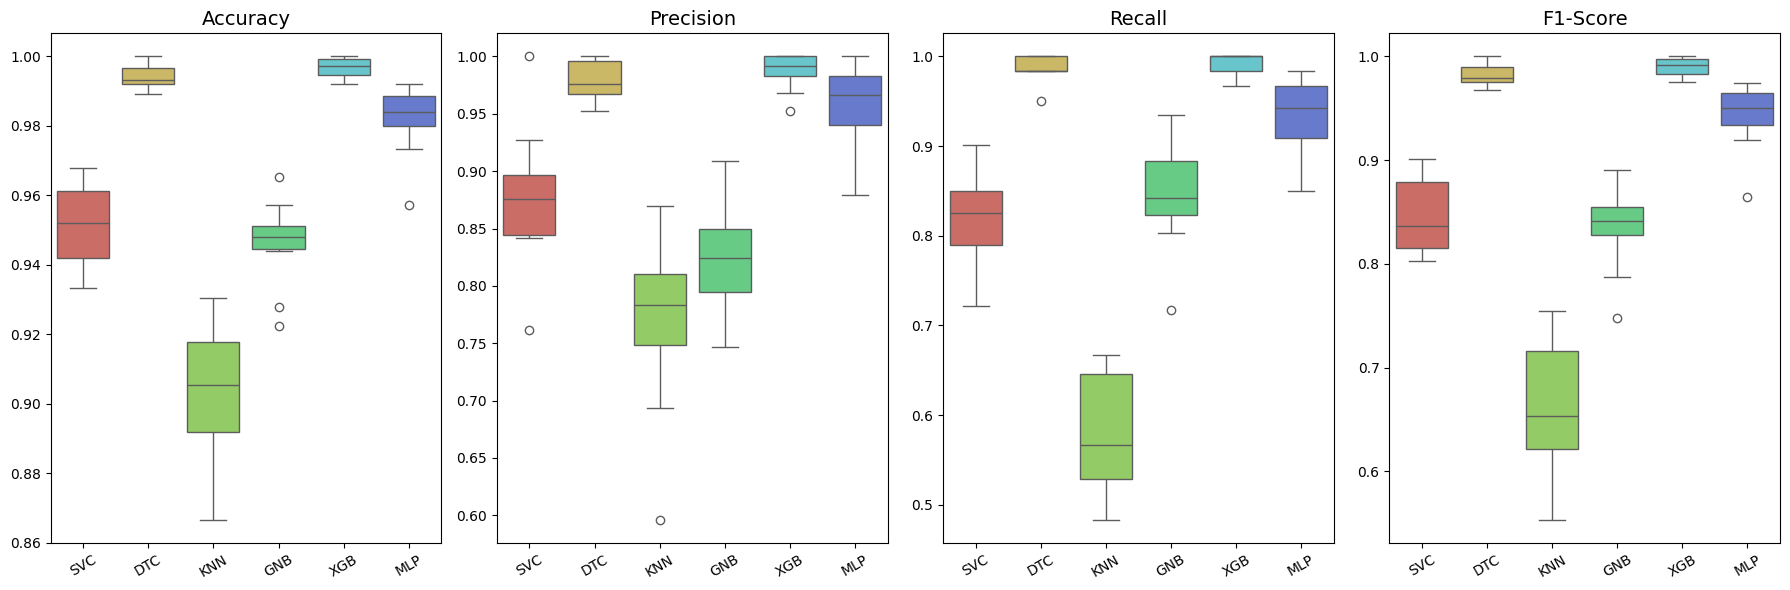

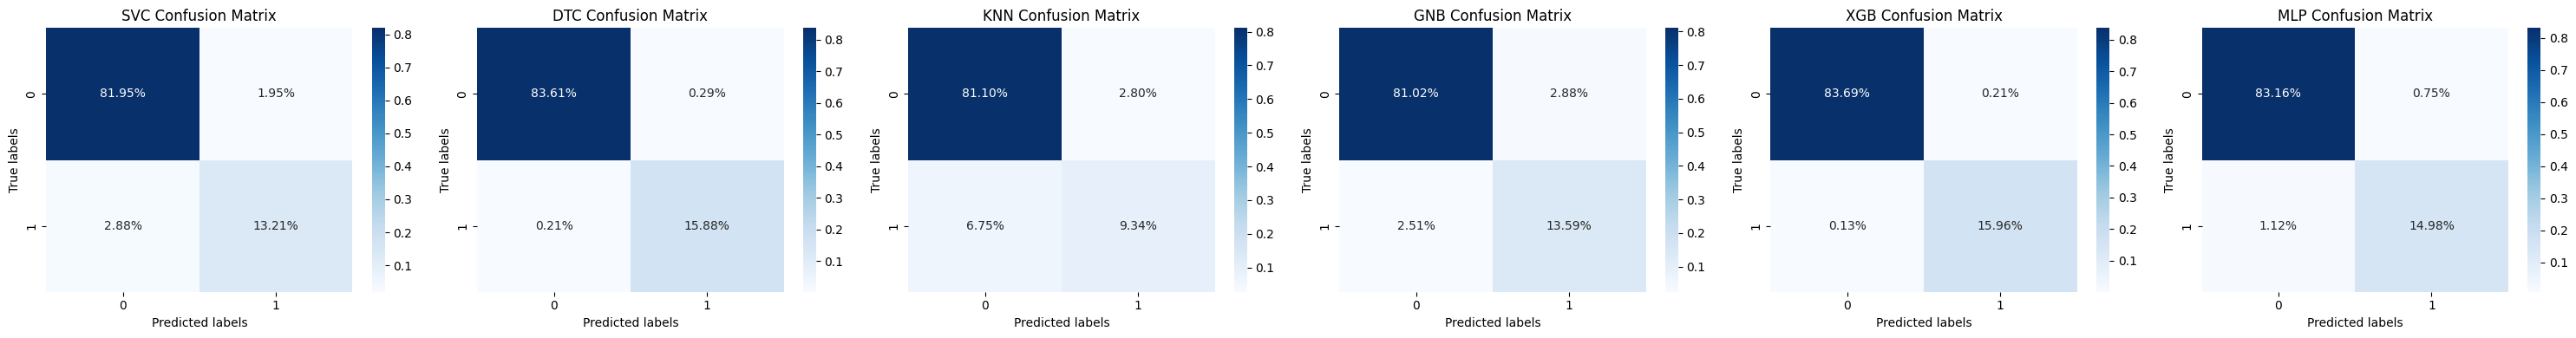

In [106]:
models = []
models.append(('SVC', SVC()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('MLP', MLPClassifier()))

model_evaluation(x_train_transformed, y_train, models)

100%|██████████| 3/3 [00:42<00:00, 14.14s/it]


           Acc Mean  Acc STD  Pre Mean  Pre STD  Rec Mean  Rec STD  F1 Mean  F1 STD  Training Time
Algorithm                                                                                         
RFC           0.996    0.004     0.989    0.016     0.985    0.019    0.987   0.011          0.423
ABC           0.995    0.004     0.985    0.017     0.983    0.015    0.984   0.011          0.327
GBC           0.995    0.004     0.987    0.019     0.983    0.020    0.985   0.012          1.358


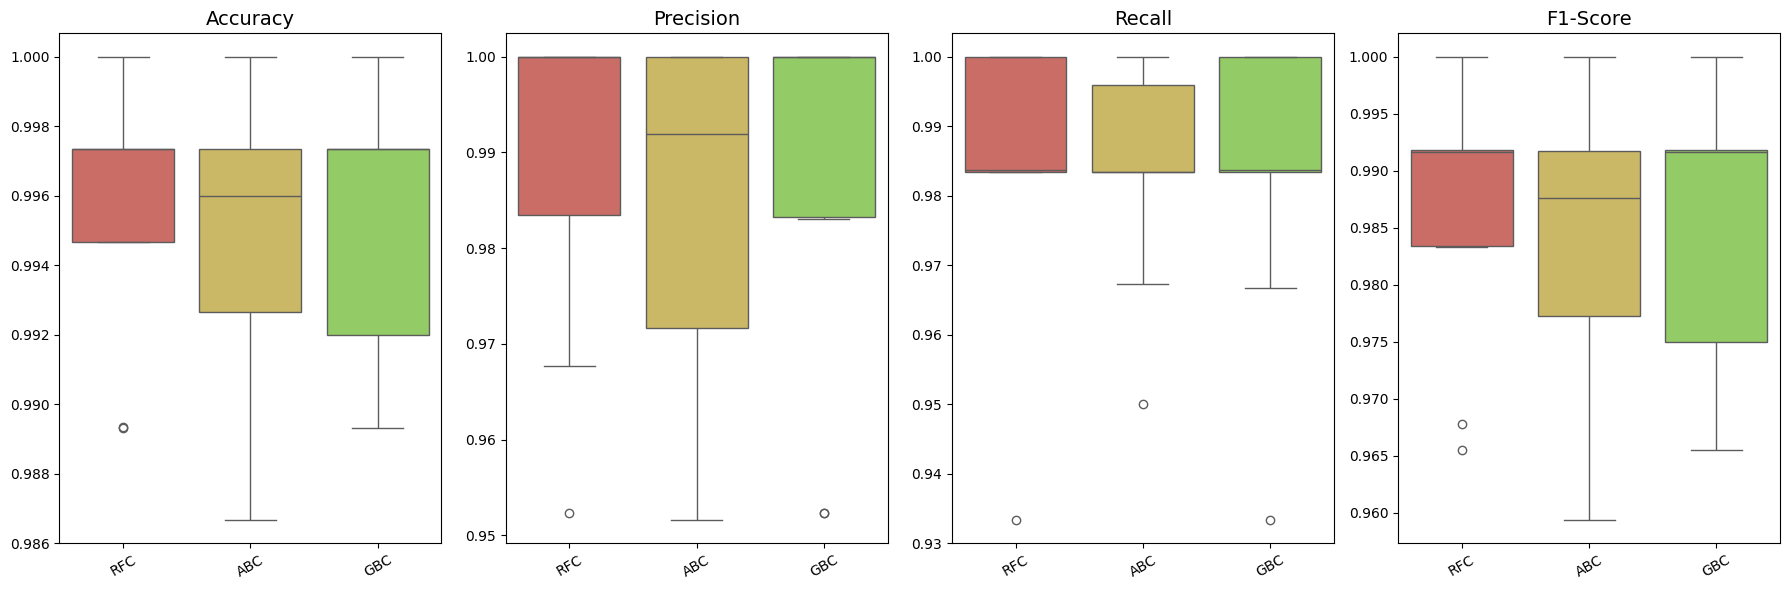

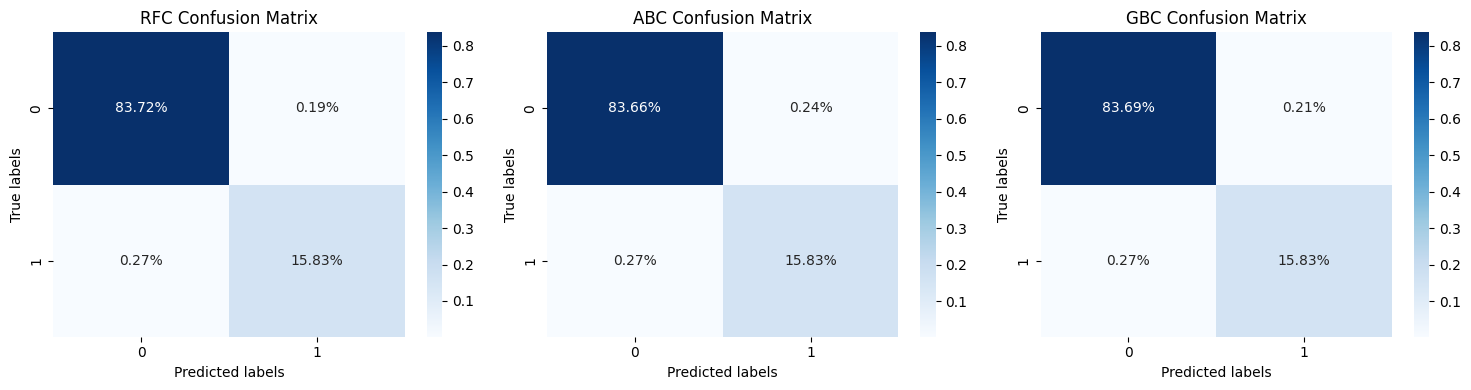

In [107]:
ens_models = []
ens_models.append(('RFC', RandomForestClassifier()))
ens_models.append(('ABC', AdaBoostClassifier(algorithm='SAMME')))
ens_models.append(('GBC', GradientBoostingClassifier()))

model_evaluation(x_train_transformed, y_train, ens_models)